# Get familiar with topic modeling

Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Import Packages
The core packages used in this tutorial are **gensim**, and **pyLDAvis**. Besides this we will also using _re_, _matplotlib_, _numpy_ and _pandas_ for data handling and visualization. Let’s import them.

In [1]:
import nltk
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Prepare Stopwords
We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import Newsgroups Data

We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as [newsgroups.json](https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json).

This is imported using _pandas.read_json_ and the resulting dataset has 3 columns as shown.

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

# To speed up, analyze only the first 1000 posts
# df = df.head(1000)

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


## Remove emails and newline characters

As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s _simple_preprocess()_ is great for this. Additionally I have set _deacc=True_ to remove the punctuations.

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s _Phrases_ model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to _Phrases_ are _min_count_ and _threshold_. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print([g for g in trigram_mod[bigram_mod[data_words[0]]] if '_'  in g])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['nntp_posting_host', 'rac_wam_umd_edu', 'maryland_college_park', 'front_bumper']


## Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.



In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


## Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

_chunksize_ is the number of documents to be used in each training chunk. _update_every_ determines how often the model parameters should be updated and _passes_ is the total number of training passes.

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using _lda_model.print_topics()_ as shown next.

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"report" + 0.027*"black" + 0.021*"fire" + 0.020*"white" + '
  '0.016*"trial" + 0.016*"cover" + 0.015*"medium" + 0.013*"vote" + '
  '0.012*"minor" + 0.012*"title"'),
 (1,
  '0.021*"god" + 0.020*"accept" + 0.016*"member" + 0.015*"man" + '
  '0.014*"israeli" + 0.014*"season" + 0.012*"publish" + 0.012*"lebanese" + '
  '0.012*"jewish" + 0.011*"brain"'),
 (2,
  '0.017*"package" + 0.016*"press" + 0.015*"item" + 0.015*"break" + '
  '0.011*"level" + 0.010*"edge" + 0.009*"hole" + 0.007*"eye" + '
  '0.007*"contribute" + 0.007*"equipment"'),
 (3,
  '0.025*"pc" + 0.022*"contain" + 0.020*"input" + 0.019*"reality" + '
  '0.017*"picture" + 0.016*"object" + 0.015*"box" + 0.015*"quality" + '
  '0.015*"level" + 0.013*"greek"'),
 (4,
  '0.089*"ax" + 0.076*"max" + 0.032*"space" + 0.021*"launch" + 0.018*"di_di" + '
  '0.017*"orbit" + 0.016*"sphere" + 0.015*"satellite" + 0.014*"plane" + '
  '0.014*"mission"'),
 (5,
  '0.019*"people" + 0.017*"kill" + 0.015*"child" + 0.015*"government" + '
  '0.0

## Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.34870618386943

Coherence Score:  0.4392813747423439


## Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.338785  0.015727       1        1  24.175812
7     -0.310562 -0.102069       2        1  15.735829
17    -0.229598  0.076681       3        1  12.438696
5     -0.141260 -0.192193       4        1   5.439879
9     -0.050106  0.253609       5        1   4.779467
6     -0.022231  0.286013       6        1   3.871267
19     0.021338 -0.011829       7        1   3.288371
8      0.040231 -0.001151       8        1   3.248170
18    -0.051460 -0.014492       9        1   3.240228
1      0.023332 -0.129415      10        1   3.160371
12     0.063571  0.065021      11        1   2.905740
2      0.114133 -0.004402      12        1   2.659833
16     0.055584 -0.140841      13        1   2.353143
10     0.111068 -0.040919      14        1   2.167395
3      0.126622  0.021171      15        1   2.005307
14     0.095816 -0.076092      16        1   1.896411
4      0.131634  0.017184      17        1   1.752176
11     0.108802  0.029884      18        1   1.743140
0      0.121497 -0.036917      19        1   1.633518
15     0.130372 -0.014969      20        1   1.505246, topic_info=           Term          Freq         Total Category  logprob  loglift
19         line  11974.000000  11974.000000  Default  30.0000  30.0000
197       write  10060.000000  10060.000000  Default  29.0000  29.0000
174       would  12046.000000  12046.000000  Default  28.0000  28.0000
139      people   5647.000000   5647.000000  Default  27.0000  27.0000
177     article   6479.000000   6479.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
3369       seat    121.922511    145.119797  Topic20  -4.9374   4.0220
756    purchase    167.433464    311.139083  Topic20  -4.6202   3.5766
521        lead    254.314007    862.157135  Topic20  -4.2022   2.9753
205   condition    153.651472    421.655835  Topic20  -4.7061   3.1867
989        stop    136.600969    898.805070  Topic20  -4.8237   2.3122

[946 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4621      6  0.991801  accelerator
1211      6  0.015121       accept
1211     10  0.984257       accept
81        3  0.007226       access
81        6  0.384790       access
...     ...       ...          ...
40        8  0.006502         year
40        9  0.371738         year
40       16  0.003110         year
720       9  0.990635    yesterday
570      14  0.998661        young

[1425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 18, 6, 10, 7, 20, 9, 19, 2, 13, 3, 17, 11, 4, 15, 5, 12, 1, 16])

##  Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to _gensim.models.wrappers.LdaMallet_. See how I have done this below.

In [14]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-02-04 13:08:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-02-04 13:08:39--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.5MB/s    in 1.5s    

2022-02-04 13:08:41 (10.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [15]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(13,
  [('good', 0.06263404385696153),
   ('make', 0.0500065654134022),
   ('thing', 0.043090996629754456),
   ('bad', 0.02652427014487679),
   ('lot', 0.024160721320085787),
   ('time', 0.020309012124130082),
   ('problem', 0.02009016501072351),
   ('give', 0.017310806670460015),
   ('pretty', 0.014947257845669016),
   ('put', 0.01398433054668009)]),
 (10,
  [('drive', 0.03356624800990624),
   ('card', 0.02806032195294534),
   ('problem', 0.02651247125420131),
   ('system', 0.022797629577215636),
   ('driver', 0.01775605872987794),
   ('work', 0.016915796921988326),
   ('bit', 0.014837254555103485),
   ('disk', 0.01457190872103308),
   ('scsi', 0.013377852467716257),
   ('run', 0.013355740314877056)]),
 (18,
  [('file', 0.04431776741329341),
   ('window', 0.02863668643596092),
   ('program', 0.019519778891000174),
   ('set', 0.016084144258267596),
   ('line', 0.012840444521218403),
   ('application', 0.01276367056294505),
   ('server', 0.010287710408629393),
   ('run', 0.009923034106

## How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The _compute_coherence_values()_ (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

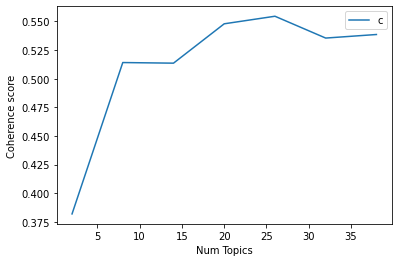

In [18]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.382
Num Topics = 8  has Coherence Value of 0.5141
Num Topics = 14  has Coherence Value of 0.5136
Num Topics = 20  has Coherence Value of 0.5479
Num Topics = 26  has Coherence Value of 0.5545
Num Topics = 32  has Coherence Value of 0.5355
Num Topics = 38  has Coherence Value of 0.5386


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [20]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.048*"post" + 0.035*"mail" + 0.026*"send" + 0.024*"group" + 0.021*"list" + '
  '0.019*"address" + 0.018*"internet" + 0.017*"information" + 0.017*"email" + '
  '0.016*"question"'),
 (1,
  '0.049*"people" + 0.028*"make" + 0.028*"thing" + 0.024*"good" + 0.016*"life" '
  '+ 0.014*"point" + 0.013*"love" + 0.012*"give" + 0.011*"bad" + 0.011*"live"'),
 (2,
  '0.020*"price" + 0.019*"line" + 0.018*"sell" + 0.017*"sale" + 0.013*"power" '
  '+ 0.010*"good" + 0.010*"current" + 0.009*"ground" + 0.009*"wire" + '
  '0.009*"high"'),
 (3,
  '0.024*"make" + 0.020*"work" + 0.017*"year" + 0.017*"money" + 0.016*"pay" + '
  '0.013*"job" + 0.013*"people" + 0.010*"time" + 0.009*"talk" + 0.008*"give"'),
 (4,
  '0.235*"write" + 0.157*"article" + 0.093*"line" + 0.040*"organization" + '
  '0.019*"hear" + 0.016*"opinion" + 0.013*"host" + 0.009*"guess" + '
  '0.008*"mention" + 0.008*"sound"'),
 (5,
  '0.037*"drive" + 0.029*"card" + 0.025*"problem" + 0.022*"system" + '
  '0.019*"driver" + 0.016*"bit" + 0.01

## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The _format_topics_sentences()_ function below nicely aggregates this information in a presentable table.

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.1897,"car, bike, buy, good, turn, ride, engine, back...",From: (wheres my thing) Subject: WHAT car is t...
1,1,0.0,0.1502,"post, mail, send, group, list, address, intern...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,5.0,0.1483,"drive, card, problem, system, driver, bit, wor...",From: (Thomas E Willis) Subject: PB questions....
3,3,4.0,0.1303,"write, article, line, organization, hear, opin...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,11.0,0.1460,"window, problem, run, set, work, application, ...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,7.0,0.2916,"gun, law, state, make, crime, case, weapon, dr...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,0.0,0.1038,"post, mail, send, group, list, address, intern...",From: (brian manning delaney) Subject: Brain T...
7,7,5.0,0.4913,"drive, card, problem, system, driver, bit, wor...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,11.0,0.1173,"window, problem, run, set, work, application, ...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,5.0,0.2456,"drive, card, problem, system, driver, bit, wor...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4821,"post, mail, send, group, list, address, intern...",Subject: Space FAQ 02/15 - Network Resources F...
1,1.0,0.5072,"people, make, thing, good, life, point, love, ...",From: (Brian Kendig) Subject: Re: Is it good t...
2,2.0,0.8051,"price, line, sell, sale, power, good, current,...",From: (Nikos I Nassuphis) Subject: LGA ncrypt ...
3,3.0,0.7663,"make, work, year, money, pay, job, people, tim...",From: (Clinton/Gore 92) Subject: CLINTON: AM P...
4,4.0,0.2968,"write, article, line, organization, hear, opin...",From: (Clayton Cramer) Subject: Re: Why not co...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The _Perc_Contribution_ column is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,19.0,"car, bike, buy, good, turn, ride, engine, back...",556.0,0.0491
1.0,0.0,"post, mail, send, group, list, address, intern...",371.0,0.0328
2.0,5.0,"drive, card, problem, system, driver, bit, wor...",727.0,0.0643
3.0,4.0,"write, article, line, organization, hear, opin...",309.0,0.0273
4.0,11.0,"window, problem, run, set, work, application, ...",567.0,0.0501
...,...,...,...,...
11309.0,10.0,"time, lot, problem, good, effect, day, find, f...",NaN,NaN
11310.0,2.0,"price, line, sell, sale, power, good, current,...",NaN,NaN
11311.0,5.0,"drive, card, problem, system, driver, bit, wor...",NaN,NaN
11312.0,6.0,"space, launch, system, time, project, cost, la...",NaN,NaN


# Hands-on!

- Adapt the code to your datasets collected from APIs (e.g. tweets about the coronavirus) and explore the results with different number of topics

- Compare sentiment among topics

- (...)